# Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3
# https://superuser.com/questions/100656/linux-unzip-command-option-to-force-overwrite
# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip -o dogImages.zip

In [5]:
# inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
# print("Input path (S3 file path): {}".format(inputs))

In [6]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
print(f'Default s3 bucket : {bucket}')
prefix = "dog-image-data"
DATASET_LOCAL_DIR = "dogImages"
role = sagemaker.get_execution_role()
role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Default s3 bucket : sagemaker-us-east-1-631507419627
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


'arn:aws:iam::631507419627:role/service-role/AmazonSageMaker-ExecutionRole-20240202T105552'

In [7]:
# print(inputs)


,# train,# valid,# test
Dog Breed,,,
001.Affenpinscher,64,8,8
002.Afghan_hound,58,7,8
003.Airedale_terrier,52,7,6
004.Akita,63,8,8
005.Alaskan_malamute,77,9,10
...,...,...,...
129.Tibetan_mastiff,48,6,6
130.Welsh_springer_spaniel,44,6,5
131.Wirehaired_pointing_griffon,30,4,3



--- Distribution ---

          # train     # valid      # test
count  133.000000  133.000000  133.000000
mean    50.225564    6.278195    6.285714
std     11.863885    1.350384    1.712571
min     26.000000    4.000000    3.000000
25%     42.000000    6.000000    5.000000
50%     50.000000    6.000000    6.000000
75%     61.000000    7.000000    8.000000
max     77.000000    9.000000   10.000000

 --- Split distribution ---


array([[<AxesSubplot:title={'center':'# train'}>,
        <AxesSubplot:title={'center':'# valid'}>],
       [<AxesSubplot:title={'center':'# test'}>, <AxesSubplot:>]],
      dtype=object)

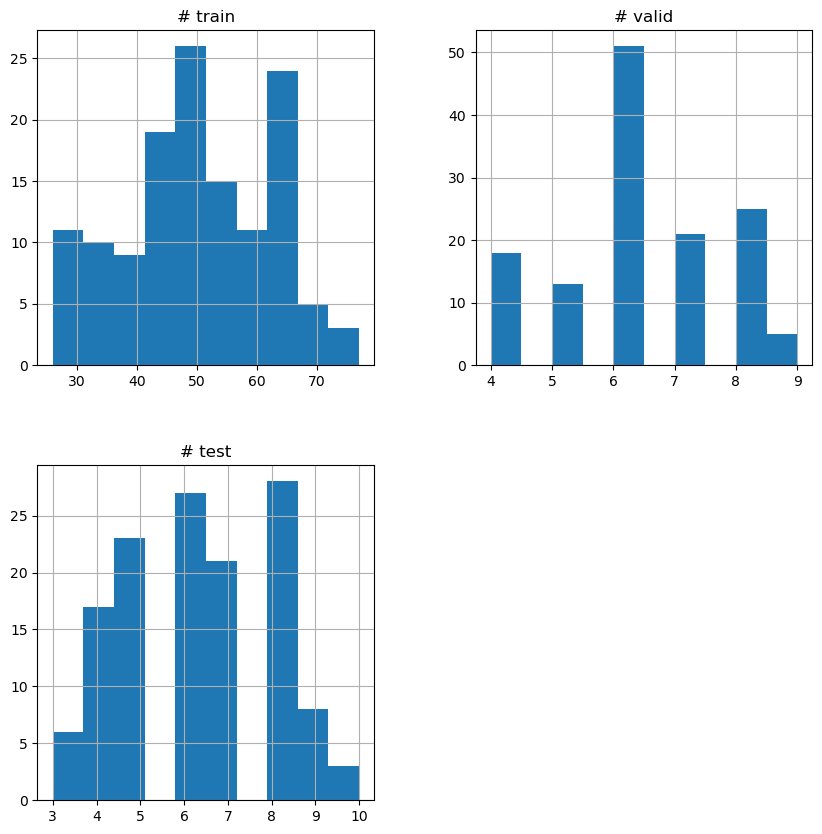

In [8]:
# Number of images for each class & their splits
classes = sorted(os.listdir(os.path.join(DATASET_LOCAL_DIR, 'train')))
num_train_images = []
num_valid_images = []
num_test_images = []

for _class in classes:
    num_train_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'train', _class))]))
    num_valid_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'valid', _class))]))
    num_test_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'test', _class))]))

df_stats = pd.DataFrame(
    {
        "Dog Breed" : list(classes),
        "# train" : num_train_images,
        "# valid" : num_valid_images,
        "# test"  : num_test_images
    }
)
df_stats = df_stats.set_index("Dog Breed")

display(df_stats)

print("\n--- Distribution ---\n")
print(df_stats.describe())

print("\n --- Split distribution ---")
display(df_stats.hist(figsize=(10, 10)))


 --- Class distribution ---


<AxesSubplot:xlabel='Dog Breed'>

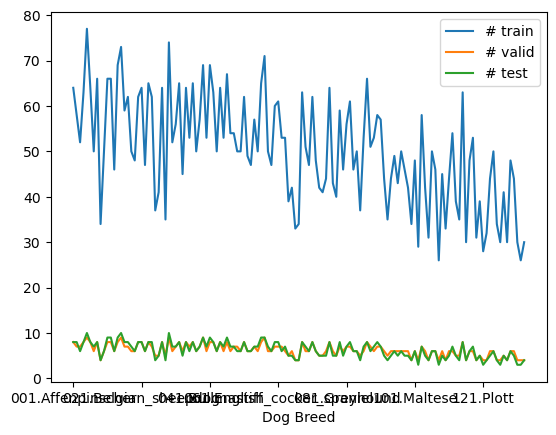

In [9]:
print("\n --- Class distribution ---")
df_stats.plot()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [10]:
# Hardcoding data set directory path to avoid re-uploading the data
dataset_dir_path = 's3://sagemaker-us-east-1-631507419627/dog-image-data'
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [11]:
from sagemaker.tuner import(
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

In [12]:
role = sagemaker.get_execution_role()
role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


'arn:aws:iam::631507419627:role/service-role/AmazonSageMaker-ExecutionRole-20240202T105552'

In [13]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [14]:
from sagemaker.pytorch import PyTorch

#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c5.2xlarge", #instance_type="ml.m5.large",
    base_job_name = 'dog-breed-classification-hpo',
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [15]:
# os.environ['SM_CHANNEL_TRAIN'] = 's3://sagemaker-us-east-1-631507419627/project3/dogImages/'
# os.environ['SM_MODEL_DIR'] = 's3://sagemaker-us-east-1-631507419627/project3/dogImages/model/'
# os.environ['SM_OUTPUT_DATA_DIR'] = 's3://sagemaker-us-east-1-631507419627/project3/dogImages/output/'

#print(f"Environment : Data_Dir: {os.environ['SM_CHANNEL_TRAIN']}, Model_Dir: {os.environ['SM_MODEL_DIR']}")

In [16]:
print(os.environ)

environ({'REGION_NAME': 'us-east-1', 'HOSTNAME': 'sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c', 'HOME': '/root', 'AWS_CONTAINER_CREDENTIALS_RELATIVE_URI': '/_sagemaker-instance-credentials/e7870b0ad008a105714524a516314769154574860f5254af7743c07b5119125b', 'PYTHONNOUSERSITE': '0', 'AWS_DEFAULT_REGION': 'us-east-1', 'SAGEMAKER_SPACE_NAME': 'deep-learning-topics-within-computer-vision-nlp-project', 'PATH': '/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/amazon/bin:/tmp/miniconda3/condabin:/tmp/anaconda3/condabin:/tmp/miniconda2/condabin:/tmp/anaconda2/condabin:/tmp/mambaforge/condabin', 'LANG': 'C.UTF-8', 'AWS_ACCOUNT_ID': '631507419627', 'DEBIAN_FRONTEND': 'noninteractive', 'SHELL': '/bin/bash', 'AWS_REGION': 'us-east-1', 'AWS_INTERNAL_IMAGE_OWNER': 'Studio', 'SAGEMAKER_APP_TYPE': 'KernelGateway', 'CONDA_DIR': '/opt/.sagemakerinternal/conda', 'LC_ALL': 'C.UTF-8', 'PWD': '/root', 'AWS_SAGEMAKER_PYTHONNOUSERSITE': '0', 'SAGEMAKER_LOG_FI

In [17]:
input_data = 's3://sagemaker-us-east-1-631507419627/dog-image-data'
input_data

's3://sagemaker-us-east-1-631507419627/dog-image-data'

In [18]:
data_paths = {'training': input_data+'/train/',
              'validation': input_data+'/valid/',
              'testing': input_data+'/test/'}
data_paths

{'training': 's3://sagemaker-us-east-1-631507419627/dog-image-data/train/',
 'validation': 's3://sagemaker-us-east-1-631507419627/dog-image-data/valid/',
 'testing': 's3://sagemaker-us-east-1-631507419627/dog-image-data/test/'}

In [19]:
# inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
# print("Input path (S3 file path): {}".format(inputs))

In [20]:
# TODO: Fit your HP Tuner
tuner.fit({"train": input_data }, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
..................................................................................................................................................................................................................................................................................!


In [21]:
tuner.best_training_job()

'pytorch-training-240204-1759-002-916db99f'

In [22]:
tuner.best_estimator()


2024-02-04 18:08:05 Starting - Found matching resource for reuse
2024-02-04 18:08:05 Downloading - Downloading the training image
2024-02-04 18:08:05 Training - Training image download completed. Training in progress.
2024-02-04 18:08:05 Uploading - Uploading generated training model
2024-02-04 18:08:05 Completed - Resource reused by training job: pytorch-training-240204-1759-003-ec5c7239


In [23]:
tuner.best_estimator().hyperparameters()


2024-02-04 18:08:05 Starting - Found matching resource for reuse
2024-02-04 18:08:05 Downloading - Downloading the training image
2024-02-04 18:08:05 Training - Training image download completed. Training in progress.
2024-02-04 18:08:05 Uploading - Uploading generated training model
2024-02-04 18:08:05 Completed - Resource reused by training job: pytorch-training-240204-1759-003-ec5c7239


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '4',
 'lr': '0.005438108615427619',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2024-02-04-17-59-26-135"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-631507419627/dog-breed-classification-hpo-2024-02-04-17-59-26-135/source/sourcedir.tar.gz"'}

In [24]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2024-02-04 18:08:05 Starting - Found matching resource for reuse
2024-02-04 18:08:05 Downloading - Downloading the training image
2024-02-04 18:08:05 Training - Training image download completed. Training in progress.
2024-02-04 18:08:05 Uploading - Uploading generated training model
2024-02-04 18:08:05 Completed - Resource reused by training job: pytorch-training-240204-1759-003-ec5c7239


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '4',
 'lr': '0.005438108615427619',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2024-02-04-17-59-26-135"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-631507419627/dog-breed-classification-hpo-2024-02-04-17-59-26-135/source/sourcedir.tar.gz"'}

In [25]:
# TODO: Get the best estimators and the best HPs
# tuner_job_name = 'pytorch-training-240203-1037'
# tuner = sagemaker.tuner.HyperparameterTuner.attach(tuner_job_name)
# best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '4',
 'lr': '0.005438108615427619',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2024-02-04-17-59-26-135"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-631507419627/dog-breed-classification-hpo-2024-02-04-17-59-26-135/source/sourcedir.tar.gz"'}

In [26]:
# Get hyperparameters of the best trained model
best_estimator_hyperparameters = best_estimator.hyperparameters()
print(best_estimator_hyperparameters)

{'_tuning_objective_metric': '"average test loss"', 'batch_size': '"64"', 'epochs': '4', 'lr': '0.005438108615427619', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"dog-breed-classification-hpo-2024-02-04-17-59-26-135"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-631507419627/dog-breed-classification-hpo-2024-02-04-17-59-26-135/source/sourcedir.tar.gz"'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [27]:
# TODO: Set up debugging and profiling rules and hooks
# hyperparameters = {
#     "lr": "0.0010569163218645224",
#     "batch-size": "64",
#     "epochs":  "2"
# }

hyperparameters={
    'lr':best_estimator.hyperparameters()['lr'],
    'batch_size':int(best_estimator.hyperparameters()['batch_size'].replace('"',"")),
    'epochs':best_estimator.hyperparameters()['epochs'].strip('"')
}

print(f"Best Hyperparamters: \n {hyperparameters}")

Best Hyperparamters: 
 {'lr': '0.005438108615427619', 'batch_size': 64, 'epochs': '4'}


In [28]:
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

In [29]:
# create rules
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

In [30]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=1)
) # 500, 10?


Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [31]:
# create debugger hook configuration

debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [ ]:
hyperparameters = {"epochs": "2", "batch-size": "32", "test-batch-size": "100", "lr": "0.001"}

In [32]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dogImageClassifier",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version="py36",
    framework_version="1.48",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
   # profiler_config=profiler_config
    
)



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [41]:
 #input_data 
estimator.fit({"train": input_data }, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dogImageClassifier-2024-02-04-20-18-22-503


Using provided s3_resource
2024-02-04 20:18:22 Starting - Starting the training job...
2024-02-04 20:18:51 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2024-02-04 20:19:52 Downloading - Downloading input data.........
2024-02-04 20:21:17 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-02-04 20:21:18,023 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-02-04 20:21:18,027 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-02-04 20:21:18,041 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-02-04 20:21:18,043 sagemaker_pytorch_container.training INFO     Invok

In [ ]:
# TODO: Plot a debugging output.

Checking trainging performance

In [42]:
import boto3
# Fetch the details of the estimator
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: dogImageClassifier-2024-02-04-20-18-22-503
Region: us-east-1


In [43]:
# Fetch the details of the estimator
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Client: {client}")
print(f"Description: {description}")

Client: <botocore.client.SageMaker object at 0x7f2231d8aec0>
Description: {'TrainingJobName': 'dogImageClassifier-2024-02-04-20-18-22-503', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:631507419627:training-job/dogImageClassifier-2024-02-04-20-18-22-503', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-631507419627/dogImageClassifier-2024-02-04-20-18-22-503/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'epochs': '"4"', 'lr': '"0.005438108615427619"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"dogImageClassifier-2024-02-04-20-18-22-503"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-631507419627/dogImageClassifier-2024-02-04-20-18-22-503/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.4-cpu-py

In [44]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
# Create a trial object from the debugging artifacts generated by the latest SageMaker training job
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-02-04 21:14:31.037 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:461 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-02-04 21:14:31.053 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:461 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-631507419627/dogImageClassifier-2024-02-04-20-18-22-503/debug-output


In [45]:
# Fetch tensor names and print their lengths
trial.tensor_names()

[2024-02-04 21:14:33.892 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:461 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-02-04 21:14:34.910 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:461 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_bn1.bias',
 'gradient/ResNet_bn1.weight',
 'gradient/ResNet_conv1.weight',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_layer1.0.bn1.bias',
 'gradient/ResNet_layer1.0.bn1.weight',
 'gradient/ResNet_layer1.0.bn2.bias',
 'gradient/ResNet_layer1.0.bn2.weight',
 'gradient/ResNet_layer1.0.conv1.weight',
 'gradient/ResNet_layer1.0.conv2.weight',
 'gradient/ResNet_layer1.1.bn1.bias',
 'gradient/ResNet_layer1.1.bn1.weight',
 'gradient/ResNet_layer1.1.bn2.bias',
 'gradient/ResNet_layer1.1.bn2.weight',
 'gradient/ResNet_layer1.1.conv1.weight',
 'gradient/ResNet_layer1.1.conv2.weight',
 'gradient/ResNet_layer2.0.bn1.bias',
 'gradient/ResNet_layer2.0.bn1.weight',
 'gradient/ResNet_layer2.0.bn2.bias',
 'gradient/ResNet_layer2.0.bn2.weight',
 'gradient/ResNet_layer2.0.conv1.weight',
 'gradient/ResNet_layer2.0.conv2.weight',
 'gradient/ResNet_layer2.0.downsample.0.weight',
 'gradient/ResNet_layer2.0.downsample.1.bias',

In [46]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.TRAIN))

TensorUnavailable: Tensor nll_loss_output_0 was not saved.

In [ ]:
# The ModeKeys class is used to specify the mode of operation for the trial object, which could be one of the following modes: ModeKeys.TRAIN, ModeKeys.EVAL, or ModeKeys.PREDICT.
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.EVAL))

In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print('Profiler report location: {}'.format(rule_output_path))

In [ ]:
! aws s3 ls {rule_output_path} --recursive


In [ ]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, "nll_loss_output_0")

In [ ]:
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

In [ ]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

In [ ]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

In [ ]:
! aws s3 ls {rule_output_path} --recursive

In [ ]:
! aws s3 cp {rule_output_path} ./ --recursive

In [ ]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()